In [1]:
# prompt: mount drive and set working directory to our current place

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Pytorch /4. Convolutional Neural Network
!pwd


Mounted at /content/drive
/content/drive/MyDrive/Pytorch /4. Convolutional Neural Network
/content/drive/MyDrive/Pytorch /4. Convolutional Neural Network


## 0. Computer Vision libraries in PyTorch

* [`torchvision`](https://www.learnpytorch.io/03_pytorch_computer_vision/) - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that we can leverage for our own problems.
* `torchvision.transforms` - functions for manipulating our vision data (images) to be suitable for use with a ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset.


In [2]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


## 1. Getting dataset

The dataset we'll be using is FashionMNIST from torchvision.datasets: https://pytorch.org/vision/0.19/generated/torchvision.datasets.FashionMNIST.html


In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root = "data", # where to download data to?
    train = True, # do we want the training dataset?
    download = True, # do we want to download yes/no?
    transform = ToTensor(), # convert data (here images) to Tensors (numbers)
    target_transform = None # how do we want to transform the target/labels?
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
# see the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.1 Check input and output shapes of data

In [8]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")

print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### 1.2 Visualizing the data

Image shape: torch.Size([1, 28, 28])


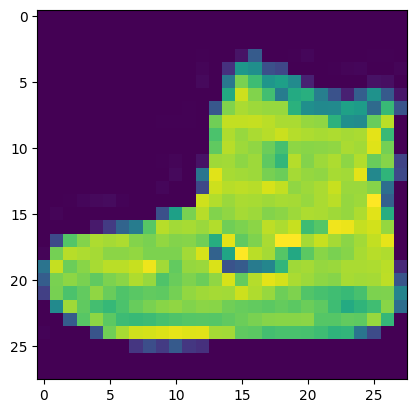

In [9]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())

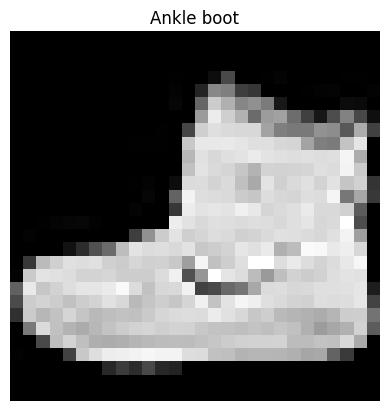

In [10]:
# Print the image in gray scale
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(class_names[label]);
plt.axis('off');

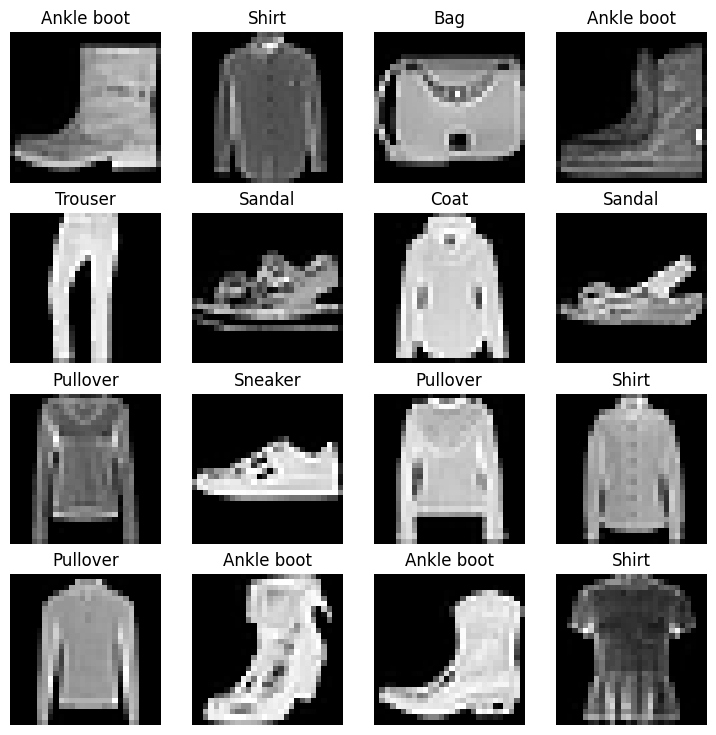

In [11]:
# Plot more random images from the data
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False);

**Question:** Do you think these items of clothing(images) could be modelled with pure linear lines? Or do you think we'll need non-linearity?

## 2. Prepare Data Loader

**Data Loader:** A data loader is a utility used in machine learning to load and manipulate datasets during training, validation, and testing phases. *It handles tasks such as reading datasets, batching, shuffling, and applying transformations, ensuring efficient and organized data flow.*

*It turns large dataset into smaller chunks (batches).

Why do we need to convert the data into smaller chunks instead of using it entirely?
* Because it's more computationally efficient.

* In an ideal world you could do the forward pass and backward pass across all of your data at once.

* But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches.

* It also gives your model more opportunities to improve.

* With mini-batches (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

What's a good batch size?

**32** is a good place to start for a fair amount of problems.

But since this is a value you can set (a hyperparameter) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 32, 64, 128, 256, 512).

For more on mini-batche, see here: https://youtu.be/I4ISUAcvHFs

In [12]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
    )

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bf4d37afb80>,
 <torch.utils.data.dataloader.DataLoader at 0x7bf4d41a89a0>)

In [13]:
# Let's check out what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7bf4d37afb80>, <torch.utils.data.dataloader.DataLoader object at 0x7bf4d41a89a0>)
Length of train dataloader: 1875 batches of 32...
Length of test dataloader: 313 batches of 32...


In [14]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
 Label: 6, label size: torch.Size([])


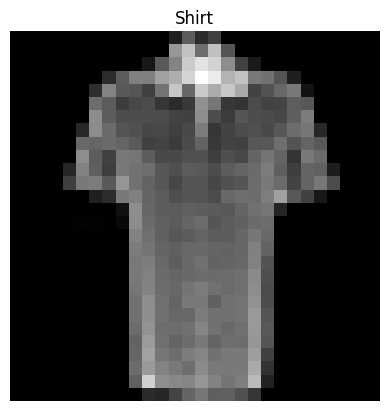

In [15]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = 'gray')
plt.title(class_names[label])
plt.axis(False);
print(f"Image size: {img.shape}")
print(f" Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

In other words: start with a very simple model and add complexity when necessary.

In [16]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]



The `nn.Flatten()` layer took our shape from [color_channels, height, width] to [color_channels, height*width].

Why do this?

Because we've now turned our pixel data from height and width dimensions into one long feature vector.

And `nn.Linear()` layers like their inputs to be in the form of feature vectors.

Let's create our first model using nn.Flatten() as the first layer.

In [17]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,
                  out_features = hidden_units),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [18]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape = 28*28,
    hidden_units = 10, #how many units in the hidden layer
    output_shape = len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [19]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss function, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `..nCrossEntropyLoss()`
* Optimizer - `torch.optim.SGD()` (Stochastic Gradient Descent)
* Evaluation metric - since we're working on a classification problem, let's use accuracy as our evaluation metric.

In [20]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [21]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

Machine Learning is very experimental.

Two of the main things you'll often want to track are:

    1. Model's performance (loss and accuracy values etc)
    2. How fast it runs

In [22]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end : float,
                     device: torch.device = None):
  """ Prints difference between start and end time

  Args:
    start (float): start time
    end (float): end time
    device (str, optional): target device to compute on. Defaults to None.
  """

  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [23]:
# Let's check the timeit function we've created
start_time = timer()
end_time = timer()
print_train_time(start = start_time,
                 end = end_time,
                 device = "cpu")

Train time on cpu: 0.000 seconds


5.5661000004647576e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the **train loss per batch**.
3. Loop through testing batches, perform testing steps, calculate the **test loss per batch**.
4. Print out what's happening
5. Time it all(for fun).

In [24]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_tim_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epochs} \n------")
  ## Training
  train_loss, train_acc = 0,0
  # Add a loop to loop through the training batches
  for batch , (X,y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss here
    # 3. Calculate accuracy
    train_acc += accuracy_fn (y_true = y,
                               y_pred = y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if batch % 400 ==0:
      print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader) # get avg loss per batch

  # Calculate train acc average per batch
  train_acc /= len(train_dataloader)



  ### Testing
  test_loss, test_acc=0,0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += accuracy_fn (y_true = y_test,
                               y_pred = test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f" \nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")


# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_tim_start_on_cpu,
                                            end = train_time_end_on_cpu,
                                            device = str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 
------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
 
Train loss: 0.59039 | Train acc: 79.17% | Test loss: 0.50954 | Test acc: 82.04%
Epoch: 3 
------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
 
Train loss: 0.47633 | Train acc: 83.32% | Test loss: 0.47989 | Test acc: 83.20%
Epoch: 3 
------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
 
Train loss: 0.45503 | Train acc: 84.05% | Test loss: 0.47664 | Test acc: 83.43%
Train time on cpu: 31.997 seconds


## 4. Make predictions and get Model 0 results

In [25]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):

  """ Returns a dictionary containing the results of model prediction on data_loader.

  Args:
    model (torch.nn.Module): A PyTorch model capable of making prediction on data_loader
    data_loader (torch.utils.data.DataLoader) : The target dataset to predict on.
    loss_fn (torch.nn.Module): The loss function of model
    accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

  Returns:
    (dict): Results of model making predicitons on data_loader.

    """

  loss, acc =0,0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # MAke predicitons with the model
      y_pred = model(X)


      # Accumulate the loss and accuracy values per batch
      loss+= loss_fn(y_pred, y)
      acc+= accuracy_fn(y_true=y,
                        y_pred = y_pred.argmax(dim=1)) # For accuracy, need the predictions labels (logits -> pred_prob -> pred_labels)

    # Scale loss and acc to find the average loss/acc per batch
    loss/=len(data_loader)
    acc/=len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}



In [26]:
# Calculate model_0 results on test dataset
model_0_results = eval_model(model = model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

Looking Good!!

We can use this dictionary to compare the baseline model results to other models later on..

## 5. Setup device agnostic-code (for using a GPU if there is one..)

In [27]:
!nvidia-smi

Fri Dec 20 18:26:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [28]:
torch.cuda.is_available()

True

In [29]:
# Setup device-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1 : Building a better model with non-linearity

In [30]:
# Create a model with linear and non-linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units: int,
               output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten inputs into a single vector
        nn.Linear(in_features = input_shape,
                  out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [31]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape = 28*28, # this is the output of the flatten layer after our 28*28 images goes in
                              hidden_units = 12,
                              output_shape = len(class_names)).to(device) # send to GPU if its available

In [32]:
model_1.parameters()

<generator object Module.parameters at 0x7bf4d2221e00>

In [33]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss() # measures how wrong our model is
optimizer = torch.optim.SGD(params = model_1.parameters(), # tries to update our model's parameters to reduce the loss
                            lr=0.1   )

### 6.2 Functionizing training and evaluation/testing loops

Let's create a funciton for:

* training loop - `train_step()`
* testing loop - `test_step()`

In [34]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to Target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [35]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(model=model_1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)

  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

# Calculate time
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu,
                                            end = train_time_end_on_cpu,
                                            device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 1.39261 | Train accuracy: 49.69%
Test loss: 1.31128 | Test accuracy: 51.02%

Epoch: 1
------
Train loss: 1.28885 | Train accuracy: 51.73%
Test loss: 1.29719 | Test accuracy: 51.89%

Epoch: 2
------
Train loss: 1.26400 | Train accuracy: 52.34%
Test loss: 1.26618 | Test accuracy: 52.57%

Train time on cuda: -1.941 seconds


In [36]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

In [37]:
# Train time on CPU
total_train_time_model_0


31.996675503999995

In [38]:
!nvidia-smi

Fri Dec 20 18:27:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0              28W /  70W |    159MiB / 15360MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU.

Why is this?

1. It could be that the overhead for copying data/model to and from the `GPU` outweighs the compute benefits offered by `GPU`.
2. The hardware you're using has a better CPU in terms of compute capability than the `GPU`.

For more on how to make your models compute faster, see here: https://horace.io/brr_intro.html

In [39]:
# GEt model_1 results dictionary

model_1_results = eval_model(model = model_1,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

It's because we've setup our data and model to use device-agnostic code but not our evaluation function.

How about we fix that by passing a target device parameter to our eval_model() function?

Then we'll try calculating the results again.

In [40]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device (makeing our model device agnostic)
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 1.2661830186843872,
 'model_acc': 52.5658945686901}

In [41]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

## Model 2: Building a Convolutional Neural Network (CNN)

CNN's are known for their capabilities to find patterns in visual data.

To find out what's happening inside a CNN, see this website:https://poloclub.github.io/cnn-explainer/

In [120]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [121]:
# Instantiate the model
torch.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape=1, # since our images are black&white
                              hidden_units=10,
                              output_shape= len(class_names)).to(device)

In [122]:
model_2.parameters

<bound method Module.parameters of FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)>

### 7.1 Stepping through nn.Conv2d..

See the documentation here:https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [123]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [124]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
conv_layer(test_image) # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input)

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

### 7.2 Stepping through `nn.MaxPool2d()`

In [125]:
test_image.shape

torch.Size([3, 64, 64])

In [126]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [127]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss funciton and optimizer for Model_2

In [128]:
# Setup loss funciton/eval metrics/ optimizer

from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

### 7.4 Training and testing `model_2` using our training and test functions

In [129]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model

epochs =3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n------")
  train_step(
      data_loader=train_dataloader,
             model=model_2,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device =device
             )
  test_step(
      data_loader = test_dataloader,
      model=model_2,
      loss_fn = loss_fn,
      accuracy_fn = accuracy_fn,
      device = device
  )


# Calculate total time taken for the model to train
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start = train_time_start_model_2,
                                            end= train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
------
Train loss: 0.59469 | Train accuracy: 78.35%
Test loss: 0.39181 | Test accuracy: 85.88%

Epoch: 1 
------
Train loss: 0.36173 | Train accuracy: 87.03%
Test loss: 0.34922 | Test accuracy: 86.96%

Epoch: 2 
------
Train loss: 0.32411 | Train accuracy: 88.30%
Test loss: 0.33190 | Test accuracy: 87.93%

Train time on cuda: 38.223 seconds


In [130]:
# Get model_2 results

model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn= loss_fn,
                             accuracy_fn = accuracy_fn,
                             device=device
                             )

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33189699053764343,
 'model_acc': 87.92931309904154}

## 8. Compare model results and training time

In [131]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                               model_1_results,
                               model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,1.266183,52.565895
2,FashionMNISTModelV2,0.331897,87.929313


In [132]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,31.996676
1,FashionMNISTModelV1,1.266183,52.565895,-1.941197
2,FashionMNISTModelV2,0.331897,87.929313,38.222692


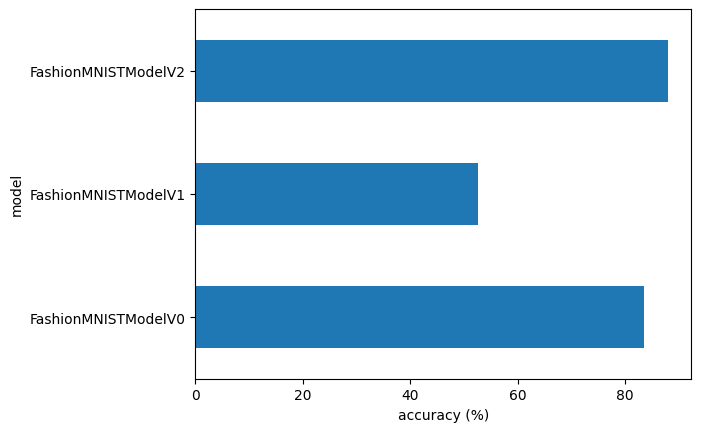

In [133]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [137]:
def make_predictions(model: torch.nn.Module,
                    data: list,
                    device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample (add batch dimension)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit, dim=1)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into tensor
    return torch.stack(pred_probs).squeeze()

In [144]:
import random
#random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 9 (Ankle boot)


In [145]:
# Make predictions
pred_probs = make_predictions(model = model_2,
                              data = test_samples)

# View first two prediction probabilities
pred_probs[:2]


tensor([[1.8362e-06, 5.3085e-07, 1.4849e-06, 1.4452e-05, 5.4603e-07, 1.5330e-03,
         2.7373e-07, 2.6806e-03, 3.4675e-03, 9.9230e-01],
        [3.7269e-05, 1.9967e-06, 1.1914e-05, 4.8196e-06, 3.1646e-06, 2.8218e-03,
         2.1372e-06, 9.6157e-01, 2.0109e-03, 3.3532e-02]])

In [146]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 7, 2, 0, 1, 0, 3, 5, 4])

In [147]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([9, 7, 2, 0, 1, 0, 4, 5, 4], tensor([9, 7, 2, 0, 1, 0, 3, 5, 4]))

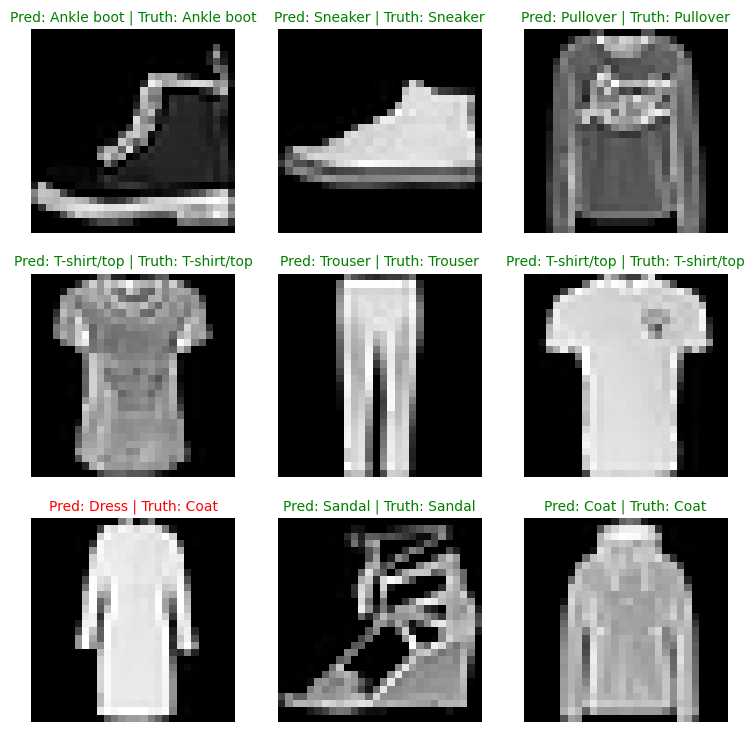

In [148]:
# Visualize our predictions
plt.figure(figsize=(9,9))
nrows, ncols = 3,3

for i, sample in enumerate(test_samples):
  # Create subplots
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap='gray')

  # Find the predicitons (in text form, e.g "sandal")
  pred_label = class_names[pred_classes[i]]

  # get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for plot
  title_next = f"Pred: {pred_label} | Truth: {truth_label}"

  # Checl for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_next, fontsize=10, c='g') # green text if prediction same as truth
  else:
    plt.title(title_next, fontsize=10, c='r') # red if prediction is not same as truth
  plt.axis(False);

## 10. Making a confusion matrix for further prediction evaluation

A [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) shows you where your classification model got confused between predictions and true labels.

To make a confusion matrix, we'll go through three steps:

1. Make predictions with our trained model, `model_2` (a confusion matrix compares predictions to true labels).
2. Make a confusion matrix using `torchmetrics.ConfusionMatrix`.
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`.

Let's start by making predictions with our trained model.

In [150]:
# Import tqdm.auto
from tqdm.auto import tqdm

# 1. Make predicitons with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc = 'Making predictions.....'):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logits = model_2(X)
    # turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
#print(y_preds)
y_pred_tensor = torch.cat(y_preds)

y_pred_tensor[:10]

Making predictions.....:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [152]:
#See if required packages are installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]>=19, "mlxtend versoin should be 0.19.0 or higher")

except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 25.7 MB/s eta 0:00:00
mlxtend version: 0.23.3


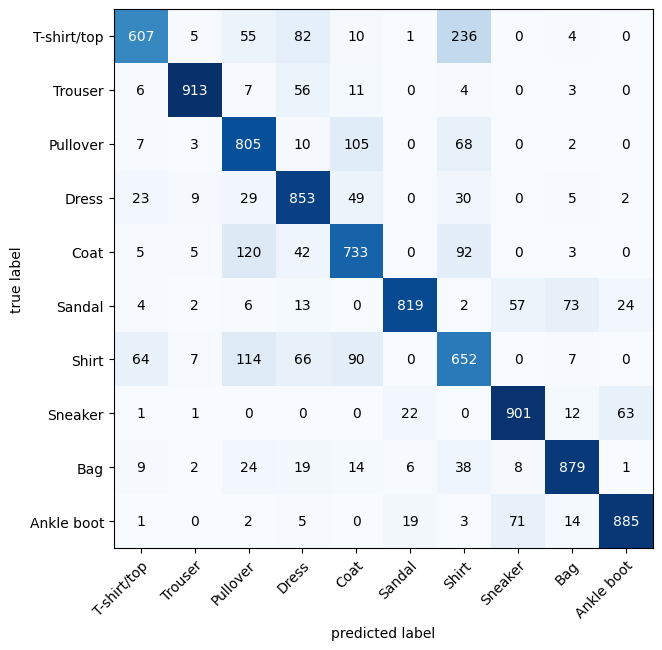

In [153]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [154]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [155]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

<ipython-input-155-01e1a5266d0e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


In [156]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33189699053764343,
 'model_acc': 87.92931309904154}

In [157]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33189699053764343,
 'model_acc': 87.92931309904154}

We can find out if two tensors are close to each other using torch.isclose() and passing in a tolerance level of closeness via the parameters atol (absolute tolerance) and rtol (relative tolerance).

If our model's results are close, the output of torch.isclose() should be true.

In [158]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)